In [1]:
import os
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import numpy as np
from configs import get_datasets
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from PIL import Image
from models import *
import torch.backends.cudnn as cudnn
from tqdm import tqdm


### config ####
num_workers = 2
batch_size = 512
img_size = 32
dataset = 'cifar10'
CACHED_MEAN_STD = {
        'cifar10': ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        'cifar100': ((0.5071, 0.4865, 0.4409), (0.2009, 0.1984, 0.2023)),
        'stl10': ((0.4409, 0.4279, 0.3868), (0.2309, 0.2262, 0.2237)),
        'imagenet': ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    }

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Visualise augmented image

In [2]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()




#### Download data ####
print('==> Preparing data..')
trainset, testset, clftrainset, num_classes, stem = get_datasets(dataset)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True,
                                          num_workers=num_workers, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False, num_workers=num_workers,
                                         pin_memory=True)
clftrainloader = torch.utils.data.DataLoader(clftrainset, batch_size=1000, shuffle=False, num_workers=num_workers,
                                             pin_memory=True)


==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
##### Transformation #####
def ColourDistortion(s=1.0):
    # s is the strength of color distortion.
    color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    rnd_color_jitter = transforms.RandomApply([color_jitter], p=0.8)
    rnd_gray = transforms.RandomGrayscale(p=0.2)
    color_distort = transforms.Compose([rnd_color_jitter, rnd_gray])
    return color_distort


transform_train = transforms.Compose([
        transforms.RandomResizedCrop(img_size, interpolation=Image.BICUBIC),
        transforms.RandomHorizontalFlip(),
        ColourDistortion(s=0.5),
        transforms.ToTensor(),
        transforms.Normalize(*CACHED_MEAN_STD[dataset]),
    ])


Files already downloaded and verified
Files already downloaded and verified


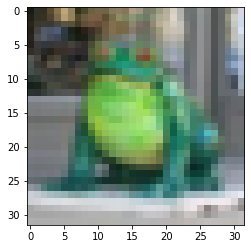

In [4]:
root = '/data/cifar10/'
train = torchvision.datasets.CIFAR10(root = root, train=True, download=True)
test = torchvision.datasets.CIFAR10(root = root, train = False, download = True)
pic = train[19][0]
plt.imshow(pic)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


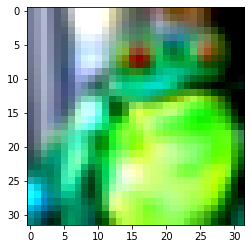

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


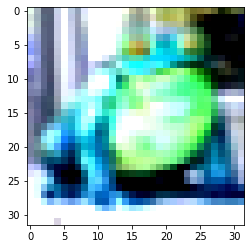

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


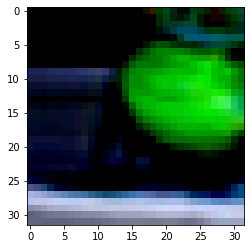

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


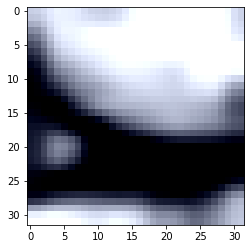

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


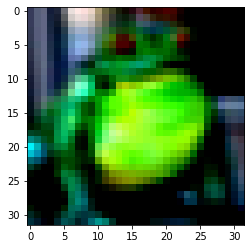

In [5]:
for i in range(5):
    tf_train = transform_train(pic)
    imshow(tf_train)

# Helper function

In [6]:
### now we put stuff together to see the distribution of p(h|x) for a pic
def get_x(data = train, sample = 100, index = 19):
    x = []
    pic = data[index][0]
    for i in range(sample):
        tf_pic = transform_train(pic)
        x.append(tf_pic)
    return x

def get_h(x, filename):
    '''
    Input: x = [tensor] , filename which is the checkpoint file
    
    Return: h|x
    '''
    ######## Load encoder from checkpoint #######
    net = ResNet18()
    net = net.to(device)

    if device == 'cuda':
        repr_dim = net.representation_dim
        net = torch.nn.DataParallel(net)
        net.representation_dim = repr_dim
        cudnn.benchmark = True

    #print('==> Loading encoder from checkpoint..')
    resume_from = os.path.join('./checkpoint', filename)
    checkpoint = torch.load(resume_from)
    net.load_state_dict(checkpoint['net'])
    
   ######## Encode ########
    h = []
    #print('==> Encoding x..')
    for i in range(len(x)):
        tf_pic = x[i]
        tf_pic = tf_pic.unsqueeze(0)
        encoded_train = net(tf_pic)
        h.append(encoded_train)
        
    return h

#### function to calculate covariance matrix and trace of cov #####

'''
Input X, filename for checkpoint

return 1) covmatrix of h|x, 2) trace of h|x, 3) log(det(covmatrix of h|x))


'''
def get_cov_h(x, filename):
    h = get_h(x, filename)
    h_np = np.array([h[i].cpu().detach().numpy()[0] for i in range(len(h))])
    covMatrix = np.cov(h_np)
    
    return covMatrix

def get_trace_h(x, filename):
    h = get_h(x, filename)
    h_np = np.array([h[i].cpu().detach().numpy()[0] for i in range(len(h))])
    covMatrix = np.cov(h_np)
    trace = np.trace(covMatrix)
    
    return trace

def get_logdetcov_h(x, filename):
    h = get_h(x, filename)
    h_np = np.array([h[i].cpu().detach().numpy()[0] for i in range(len(h))])
    covMatrix = np.cov(h_np)
    log_det = np.log(np.linalg.det(covMatrix))
    
    return log_det


In [7]:
def gen_data(B = 500,num_aug = 100):
    '''
    B = image batch
    num_aug = number of augmented picture for each image 
    '''
    pic_index_train = np.random.randint(low = 0, high = len(train), size = B)
    pic_index_test = np.random.randint(low = 0, high = len(test), size = B)
    #sample augmented image !
    X_train = [get_x(data = train, sample = num_aug, index = pic_index_train[i]) for i in range(B)]
    X_test = [get_x(data = test, sample = num_aug, index = pic_index_test[i]) for i in range(B)]
    
    return X_train, X_test

#helper function to plot
def my_plot(train_dict, test_dict, title = 'trace of covariance h|x'):
    plt.plot([99+ 100*i for i in range(10)], [train_dict[cp] for cp in checkpointfile], label = 'train', color = 'b')
    plt.plot([99+ 100*i for i in range(10)], [test_dict[cp] for cp in checkpointfile], label = 'test', color = 'r')
    plt.xlabel('epochs')
    plt.title(title)
    plt.legend()
    plt.show()

# Now we calculate E_x( h|x)

In [8]:
randomseed = 1
np.random.seed(randomseed)

In [9]:
X_train, X_test = gen_data(B = 50, num_aug = 100)
trace_h_train = {}
trace_h_test = {}
checkpointfile = ['resnet18.pth99']+ ['resnet18.pth' + str(i) + '99' for i in range(1,10)]
for cp in tqdm(checkpointfile):
    
    # Expected trace (h|x)
    mean_trace_train = np.mean([get_trace_h(X_train[i], cp) for i in range(len(X_train))])
    trace_h_train[cp] = mean_trace_train
    
    mean_trace_test = np.mean([get_trace_h(X_test[i], cp) for i in range(len(X_test))])
    trace_h_test[cp] = mean_trace_test


100%|██████████| 10/10 [11:29<00:00, 68.97s/it]


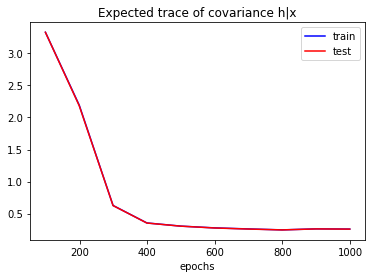

In [10]:
my_plot(trace_h_train, trace_h_test, title = 'Expected trace of covariance h|x')

In [11]:
X_train, X_test = gen_data(B = 50, num_aug = 100)
logdetcov_h_train = {}
logdetcov_h_test = {}
checkpointfile = ['resnet18.pth99']+ ['resnet18.pth' + str(i) + '99' for i in range(1,10)]
for cp in tqdm(checkpointfile):
    
    # Expected trace (h|x)
    mean_trace_train = np.mean([get_trace_h(X_train[i], cp) for i in range(len(X_train))])
    trace_h_train[cp] = mean_trace_train
    
    mean_trace_test = np.mean([get_trace_h(X_test[i], cp) for i in range(len(X_test))])
    trace_h_test[cp] = mean_trace_test
    
    # Expected log ( det (cov (h|x)))
    mean_logdetcov_train = np.mean([get_logdetcov_h(X_train[i], cp) for i in range(len(X_train))])
    logdetcov_h_train[cp] = mean_logdetcov_train
    
    mean_logdetcov_test = np.mean([get_logdetcov_h(X_test[i], cp) for i in range(len(X_test))])
    logdetcov_h_test[cp] = mean_logdetcov_test


100%|██████████| 10/10 [23:24<00:00, 140.41s/it]


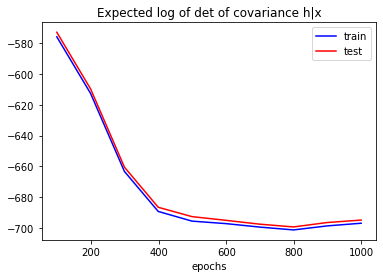

In [12]:
my_plot(logdetcov_h_train, logdetcov_h_test, title = 'Expected log of det of covariance h|x')

In [13]:
logdetcov_h_train

{'resnet18.pth99': -575.9952607676927,
 'resnet18.pth199': -612.7416973169213,
 'resnet18.pth299': -663.2440603951973,
 'resnet18.pth399': -689.163248498339,
 'resnet18.pth499': -695.4393763367708,
 'resnet18.pth599': -697.0406102184579,
 'resnet18.pth699': -699.2958670840171,
 'resnet18.pth799': -701.1273249682214,
 'resnet18.pth899': -698.514843450494,
 'resnet18.pth999': -696.7909081260503}

# Look at E(Tr h)

In [14]:
# helper function for E(Tr h)
def get_trace_h2(x, filename):
    h = [get_h([x[i]], filename)[0] for i in range(len(x))]
    h_np = np.array([h[i].cpu().detach().numpy()[0] for i in range(len(h))])
    covMatrix = np.cov(h_np)
    trace = np.trace(covMatrix)
    
    return trace


def get_cov_h2(x, filename):
    h = [get_h([x[i]], filename)[0] for i in range(len(x))]
    h_np = np.array([h[i].cpu().detach().numpy()[0] for i in range(len(h))])
    covMatrix = np.cov(h_np)
    
    return covMatrix

In [15]:
# This is similar to above but we take one augmentation for each image
X_train, X_test = gen_data(B = 200, num_aug = 1)
#combine into a single list
X_train = [X_train[i][0] for i in range(len(X_train))]
X_test = [X_test[i][0] for i in range(len(X_test))]

trace_h_train2 = {}
trace_h_test2 = {}
checkpointfile = ['resnet18.pth99']+ ['resnet18.pth' + str(i) + '99' for i in range(1,10)]
for cp in tqdm(checkpointfile):
    trace_train = get_trace_h2(X_train, cp)
    trace_h_train2[cp] = trace_train
    
    trace_test = get_trace_h2(X_test, cp)
    trace_h_test2[cp] = trace_test

100%|██████████| 10/10 [14:05<00:00, 84.53s/it]


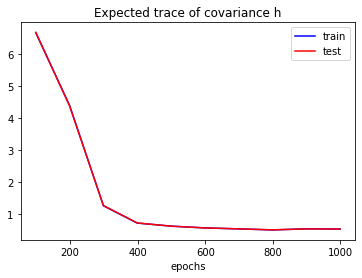

In [16]:
my_plot(trace_h_train2, trace_h_test2, title = 'Expected trace of covariance h')

In [17]:
logdetcov_h_train2 = {}
logdetcov_h_test2 = {}
checkpointfile = ['resnet18.pth99']+ ['resnet18.pth' + str(i) + '99' for i in range(1,10)]
for cp in tqdm(checkpointfile):
    cov_train = get_cov_h2(X_train, cp)
    log_det_train = np.log(np.linalg.det(cov_train))
    print(log_det_train)
    logdetcov_h_train2[cp] = log_det_train
    
#     cov_test = get_cov_h2(X_test, cp)
#     log_det_test = np.log(np.linalg.det(cov_test))
#     logdetcov_h_test2[cp] = log_det_test

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
 10%|█         | 1/10 [00:42<06:19, 42.16s/it]

-inf


 20%|██        | 2/10 [01:24<05:37, 42.16s/it]

-inf


 30%|███       | 3/10 [02:06<04:55, 42.19s/it]

-inf


 40%|████      | 4/10 [02:48<04:13, 42.23s/it]

-inf


 50%|█████     | 5/10 [03:31<03:30, 42.20s/it]

-inf


 60%|██████    | 6/10 [04:13<02:48, 42.22s/it]

-inf


 70%|███████   | 7/10 [04:55<02:06, 42.24s/it]

-inf


 80%|████████  | 8/10 [05:37<01:24, 42.23s/it]

-inf


 90%|█████████ | 9/10 [06:19<00:42, 42.19s/it]

-inf


100%|██████████| 10/10 [07:02<00:00, 42.22s/it]

-inf


KeyError: 'resnet18.pth99'

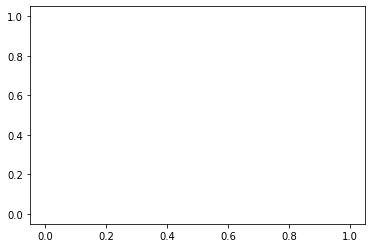

In [18]:
my_plot(logdetcov_h_train2, logdetcov_h_test2, title = 'Expected log of det of covariance h')

In [19]:
logdetcov_h_train2

{'resnet18.pth99': -inf,
 'resnet18.pth199': -inf,
 'resnet18.pth299': -inf,
 'resnet18.pth399': -inf,
 'resnet18.pth499': -inf,
 'resnet18.pth599': -inf,
 'resnet18.pth699': -inf,
 'resnet18.pth799': -inf,
 'resnet18.pth899': -inf,
 'resnet18.pth999': -inf}